# Introduction

This notebook demonstrates basic usage of BioThings Explorer, an engine for autonomously querying a distributed knowledge graph. BioThings Explorer can answer two classes of queries -- "PREDICT" and "EXPLAIN".  PREDICT queries are described in [PREDICT_demo.ipynb](PREDICT_demo.ipynb). Here, we describe EXPLAIN queries and how to use BioThings Explorer to execute them.  A more detailed overview of the BioThings Explorer systems is provided in [these slides](https://docs.google.com/presentation/d/1QWQqqQhPD_pzKryh6Wijm4YQswv8pAjleVORCPyJyDE/edit?usp=sharing).

EXPLAIN queries are designed to **identify plausible reasoning chains to explain the relationship between two entities**.  For example, in this notebook, we explore the question:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"*Why does imatinib have an effect on the treatment of chronic myelogenous leukemia (CML)?*"  

Later, we also compare those results to a similar query looking at imatinib's role in treating gastrointestinal stromal tumors (GIST).

**To experiment with an executable version of this notebook, [load it in Google Colaboratory](https://colab.research.google.com/github/biothings/biothings_explorer/tree/reasoner/jupyter%20notebooks/EXPLAIN_demo.ipynb).**

## Step 0: Load BioThings Explorer modules

First, install the `biothings_explorer` and `biothings_schema` packages, as described in this [README](https://github.com/biothings/biothings_explorer/blob/master/jupyter%20notebooks/README.md#prerequisite).  This only needs to be done once (but including it here for compability with [colab](https://colab.research.google.com/)).

In [1]:
!pip install git+https://github.com/biothings/biothings_explorer.git@add_data_tools

  Cloning https://github.com/biothings/biothings_explorer to /private/var/folders/59/w2v_bg_d2rj_hg69468vdxzw0000gn/T/pip-install-87l7sgk0/biothings-explorer
  Running command git clone -q https://github.com/biothings/biothings_explorer /private/var/folders/59/w2v_bg_d2rj_hg69468vdxzw0000gn/T/pip-install-87l7sgk0/biothings-explorer
  Running command git submodule update --init --recursive -q
  Stored in directory: /private/var/folders/59/w2v_bg_d2rj_hg69468vdxzw0000gn/T/pip-ephem-wheel-cache-mp83lp3v/wheels/61/44/e1/901cb798059240028e8e2b5d8ed46a47aafa11af30a20c465a
Successfully built biothings-explorer
You should consider upgrading via the 'pip install --upgrade pip' command.


Next, import the relevant modules:

* **Hint**: Find corresponding bio-entity representation used in BioThings Explorer based on user input (could be any database IDs, symbols, names)
* **FindConnection**: Find intermediate bio-entities which connects user specified input and output

In [1]:
# import modules from biothings_explorer
from biothings_explorer.hint import Hint
from biothings_explorer.user_query_dispatcher import FindConnection

## Step 1: Find representation of "chronic myelogenous leukemia" and "imatinib" in BTE

In this step, BioThings Explorer translates our query strings "chronic myelogenous leukemia" and "imatinib" into BioThings objects, which contain mappings to many common identifiers.  Generally, the top result returned by the `Hint` module will be the correct item, but you should confirm that using the identifiers shown.

Search terms can correspond to any child of [BiologicalEntity](https://biolink.github.io/biolink-model/docs/BiologicalEntity.html) from the [Biolink Model](https://biolink.github.io/biolink-model/docs/), including `DiseaseOrPhenotypicFeature` (e.g., "lupus"), `ChemicalSubstance` (e.g., "acetaminophen"), `Gene` (e.g., "CDK2"), `BiologicalProcess` (e.g., "T cell differentiation"), and `Pathway` (e.g., "Citric acid cycle").

In [2]:
ht = Hint()
# find all potential representations of CML
cml_hint = ht.query("chronic myelogenous leukemia")
# select the correct representation of CML
cml = cml_hint['DiseaseOrPhenotypicFeature'][0]
cml

{'mondo': 'MONDO:0011996',
 'doid': 'DOID:8552',
 'umls': 'C1292772',
 'mesh': 'D015464',
 'name': 'chronic myelogenous leukemia',
 'display': 'mondo(MONDO:0011996) doid(DOID:8552) umls(C1292772) mesh(D015464) name(chronic myelogenous leukemia) ',
 'type': 'DiseaseOrPhenotypicFeature',
 'primary': {'identifier': 'mondo',
  'cls': 'DiseaseOrPhenotypicFeature',
  'value': 'MONDO:0011996'}}

In [3]:
# find all potential representations of imatinib
imatinib_hint = ht.query("imatinib")
# select the correct representation of imatinib
imatinib = imatinib_hint['ChemicalSubstance'][0]
imatinib

{'chembl': 'CHEMBL941',
 'drugbank': 'DB00619',
 'name': 'Imatinib',
 'pubchem': 5291,
 'umls': 'C0935989',
 'mesh': 'D000068877',
 'chebi': 'CHEBI:45783',
 'smiles': 'Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1',
 'display': 'chembl(CHEMBL941) drugbank(DB00619) name(Imatinib) pubchem(5291) umls(C0935989) mesh(D000068877) chebi(CHEBI:45783) smiles(Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1) ',
 'type': 'ChemicalSubstance',
 'primary': {'identifier': 'chembl',
  'cls': 'ChemicalSubstance',
  'value': 'CHEMBL941'}}

## Step 2: Find intermediate nodes connecting imatinib and chronic myelogenous leukemia

In this section, we find all paths in the knowledge graph that connect imatinib and chronic myelogenous leukemia.  To do that, we will use `FindConnection`.  This class is a convenient wrapper around two advanced functions for **query path planning** and **query path execution**. More advanced features for both query path planning and query path execution are in development and will be documented in the coming months. 

The parameters for `FindConnection` are described below:


In [5]:
help(FindConnection.__init__)

Help on function __init__ in module biothings_explorer.user_query_dispatcher:

__init__(self, input_obj, output_obj, intermediate_nodes, registry=None)
    Find relationships in the Knowledge Graph between an Input Object and an Output Object.
    
    Args:
        input_obj (required): must be an object returned from Hint corresponding to a specific biomedical entity.
                            Examples: 
                Hint().query("Fanconi anemia")['DiseaseOrPhenotypicFeature'][0]
                Hint().query("acetaminophen")['ChemicalSubstance'][0]
    
        output_obj (required): must EITHER be an object returned from Hint corresponding to a specific biomedical
                            entity, OR be a string or list of strings corresponding to Biolink Entity classes.
                            Examples:
                Hint().query("acetaminophen")['ChemicalSubstance'][0]
                'Gene'
                ['Gene','ChemicalSubstance']
    
        intermediate_nodes 

Here, we formulate a `FindConnection` query with "CML" as the `input_ojb`, "imatinib" as the `output_obj`.  We further specify with the `intermediate_nodes` parameter that we are looking for paths joining chronic myelogenous leukemia and imatinib with *one* intermediate node that is a Gene.  (The ability to search for longer reasoning paths that include additional intermediate nodes will be added shortly.)

In [4]:
fc = FindConnection(input_obj=cml, output_obj=imatinib, intermediate_nodes='Gene')

We next execute the `connect` method, which performs the **query path planning** and **query path execution** process.  In short, BioThings Explorer is deconstructing the query into individual API calls, executing those API calls, then assembling the results.

A verbose log of this process is displayed below:

In [5]:
# set verbose=True will display all steps which BTE takes to find the connection
fc.connect(verbose=True)

========== QUERY PARAMETER SUMMARY ==========

BTE will find paths that join 'chronic myelogenous leukemia' and 'Imatinib'. Paths will have 1 intermediate node.

Intermediate node #1 will have these type constraints: Gene


========== QUERY #1 -- fetch all Gene entities linked to 'chronic myelogenous leukemia' ==========

==== Step #1: Query path planning ====

Because chronic myelogenous leukemia is of type 'DiseaseOrPhenotypicFeature', BTE will query our meta-KG for APIs that can take 'DiseaseOrPhenotypicFeature' as input and 'Gene' as output

BTE found 7 apis:

API 1. mydisease.info(1 API call)
API 2. mgigene2phenotype(1 API call)
API 3. corddisease(1 API call)
API 4. scibite_disease2gene(1 API call)
API 5. DISEASES(1 API call)
API 6. biolink_disease2gene(1 API call)
API 7. semmeddisease(1 API call)


==== Step #2: Query path execution ====
NOTE: API requests are dispatched in parallel, so the list of APIs below is ordered by query time.

API 1.1: http://mydisease.info/v1/query (POS

## Step 3: Display and Filter results
This section demonstrates post-query filtering done in Python. Later, more advanced filtering functions will be added to the **query path execution** module for interleaved filtering, thereby enabling longer query paths. More details to come...

First, all matching paths can be exported to a data frame. Let's examine a sample of those results.

In [6]:
df = fc.display_table_view()

# because UMLS is not currently well-integrated in our ID-to-object translation system, removing UMLS-only entries here
patternDel = "^umls:C\d+"
filter = df.node1_id.str.contains(patternDel)
df = df[~filter]

df1 = df.sample(10)

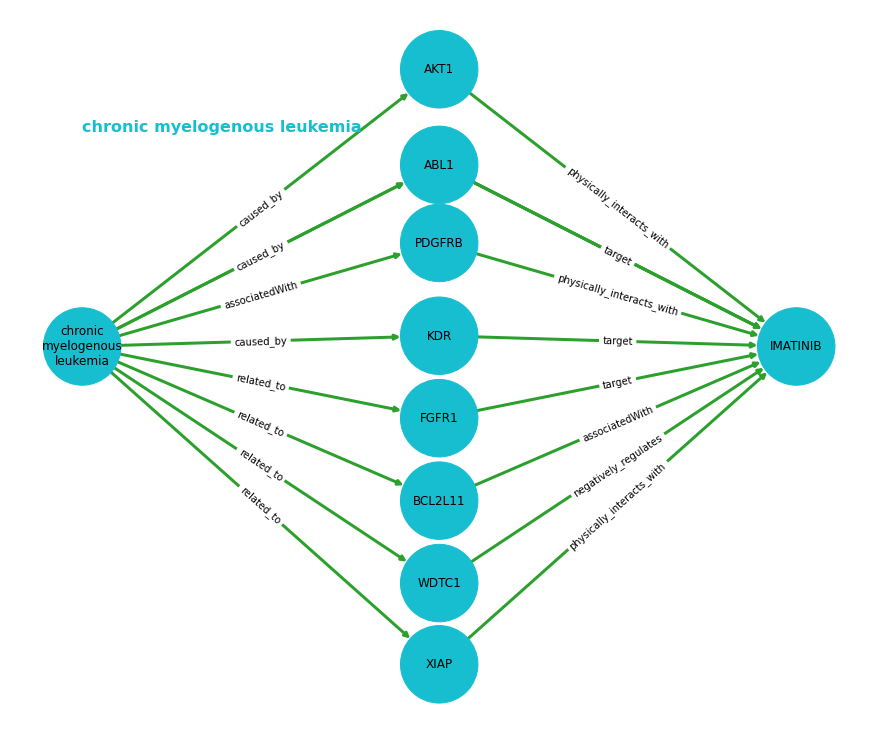

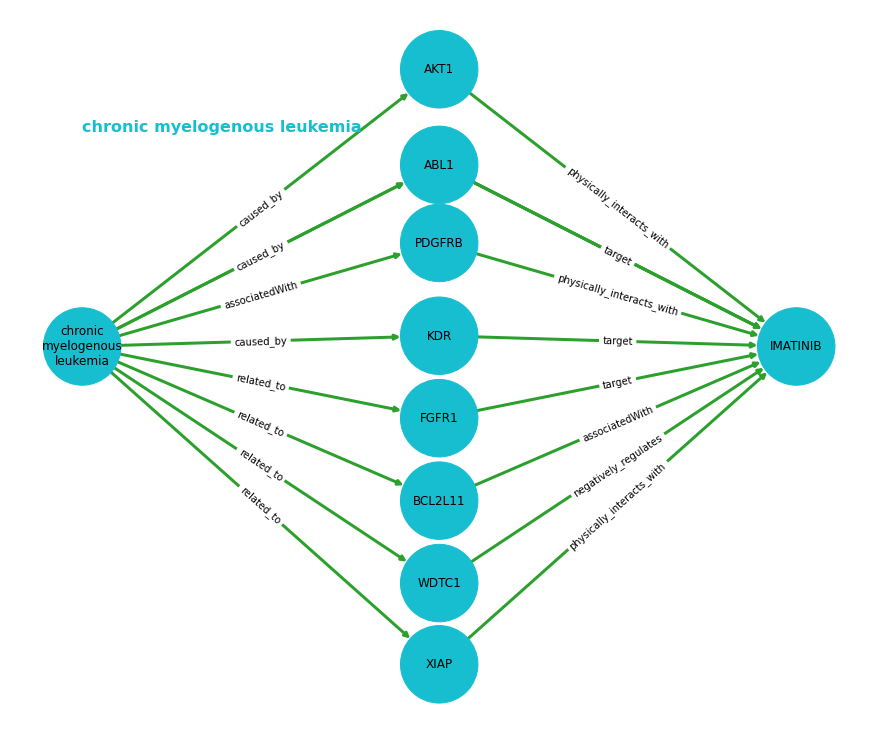

In [8]:
%matplotlib inline

from biothings_explorer.utils.visualize import visualize

visualize(df1)

While most results are based on edges from [semmed](https://skr3.nlm.nih.gov/SemMed/), edges from [DGIdb](http://www.dgidb.org/), [biolink](https://monarchinitiative.org/), [disgenet](http://www.disgenet.org/), [mydisease.info](https://mydisease.info) and [drugcentral](http://drugcentral.org/) were also retrieved from their respective APIs.  

Next, let's look to see which genes are mentioned the most.

In [10]:
df.node1_name.value_counts().head(10)

ABL1     77
BCR      49
ABCB1    27
KIT      24
GSTP1    18
AKT1     15
MYC      10
ABCC1    10
JAK2     10
TNF       9
Name: node1_name, dtype: int64

Not surprisingly, the top two genes that BioThings Explorer found that join imatinib to CML are *ABL1* and *BCR*, the two genes that are fused in the "Philadelphia chromosome", the genetic abnormality that underlies CML, *and* the validate target of imatinib.

Let's examine some of the PubMed articles linking **CML to *ABL1*** and ***ABL1* to imatinib**.

In [13]:
# fetch all articles connecting 'chronic myelogenous leukemia' and 'ABL1'
articles = []
for info in fc.display_edge_info('chronic myelogenous leukemia', 'ABL1').values():
    if 'pubmed' in info['info']:
        articles += info['info']['pubmed']
print("There are "+str(len(articles))+" articles supporting the edge between CML and ABL1. Sampling of 10 of those:")
x = [print("http://pubmed.gov/"+str(x)) for x in articles[0:10] ]

There are 15 articles supporting the edge between CML and ABL1. Sampling of 10 of those:
http://pubmed.gov/11979553
http://pubmed.gov/10498618
http://pubmed.gov/10822991
http://pubmed.gov/11368359
http://pubmed.gov/20809971
http://pubmed.gov/18082628
http://pubmed.gov/18243808
http://pubmed.gov/23287430
http://pubmed.gov/21955823
http://pubmed.gov/23637631


In [14]:
# fetch all articles connecting 'ABL1' and 'Imatinib
articles = []
for info in fc.display_edge_info('ABL1', 'Imatinib').values():
    if 'pubmed' in info['info']:
        articles += info['info']['pubmed']
print("There are "+str(len(articles))+" articles supporting the edge between ABL1 and imatinib. Sampling of 10 of those:")
x = [print("http://pubmed.gov/"+str(x)) for x in articles[0:10] ]

There are 25 articles supporting the edge between ABL1 and imatinib. Sampling of 10 of those:
http://pubmed.gov/15799618
http://pubmed.gov/15917650
http://pubmed.gov/15949566
http://pubmed.gov/16153117
http://pubmed.gov/16205964
http://pubmed.gov/19937285
http://pubmed.gov/12032135
http://pubmed.gov/12446442
http://pubmed.gov/15039284
http://pubmed.gov/15107311


## Comparing results between CML and GIST

Let's perform another BioThings Explorer query, this time looking to EXPLAIN the relationship between imatinib and gastrointestinal stromal tumors (GIST), another disease treated by imatinib.

In [15]:
ht = Hint()
# find all potential representations of CML
gist_hint = ht.query("gastrointestinal stromal tumor")
# select the correct representation of CML
gist = gist_hint['DiseaseOrPhenotypicFeature'][0]
gist

{'mondo': 'MONDO:0011719',
 'doid': 'DOID:9253',
 'umls': 'C3179349',
 'mesh': 'D046152',
 'name': 'gastrointestinal stromal tumor',
 'display': 'mondo(MONDO:0011719) doid(DOID:9253) umls(C3179349) mesh(D046152) name(gastrointestinal stromal tumor) ',
 'type': 'DiseaseOrPhenotypicFeature',
 'primary': {'identifier': 'mondo',
  'cls': 'DiseaseOrPhenotypicFeature',
  'value': 'MONDO:0011719'}}

In [16]:
fc = FindConnection(input_obj=gist, output_obj=imatinib, intermediate_nodes='Gene')

In [17]:
fc.connect(verbose=False) # skipping the verbose log here

0, message='Attempt to decode JSON with unexpected mimetype: text/plain;charset=utf-8'
0, message='Attempt to decode JSON with unexpected mimetype: text/plain;charset=utf-8'


In [18]:
df = fc.display_table_view()

# because UMLS is not currently well-integrated in our ID-to-object translation system, removing UMLS-only entries here
patternDel = "^umls:C\d+"
filter = df.node1_id.str.contains(patternDel)
df = df[~filter]

df.sample(10)

,input,input_type,pred1,pred1_source,pred1_api,pred1_pubmed,node1_id,node1_name,node1_type,pred2,pred2_source,pred2_api,pred2_pubmed,output_id,output_name,output_type
82,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,semmed,semmeddisease,18615679,entrez:673,BRAF,Gene,associatedWith,ctd,ctd_chemical2gene,19937285,chembl:CHEMBL941,IMATINIB,ChemicalSubstance
177,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,DISEASES,DISEASES,None,entrez:5156,PDGFRA,Gene,associatedWith,ctd,ctd_chemical2gene,22447953,chembl:CHEMBL941,IMATINIB,ChemicalSubstance
304,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,semmed,semmeddisease,"15869870,15709888,22652566,25544564,26349547,1...",entrez:3815,KIT,Gene,associatedWith,ctd,ctd_chemical2gene,"17420286,27793025",chembl:CHEMBL941,IMATINIB,ChemicalSubstance
58,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,semmed,semmeddisease,21163869,entrez:5243,ABCB1,Gene,associatedWith,ctd,ctd_chemical2gene,27262785,chembl:CHEMBL941,IMATINIB,ChemicalSubstance
208,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,disgenet,mydisease.info,None,entrez:5156,PDGFRA,Gene,associatedWith,ctd,ctd_chemical2gene,"15786421,17614352,28347583",chembl:CHEMBL941,IMATINIB,ChemicalSubstance
23,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,semmed,semmeddisease,15297464,entrez:2322,FLT3,Gene,target,drugcentral,mychem.info,None,chembl:CHEMBL941,IMATINIB,ChemicalSubstance
257,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,causedBy,semmed,semmeddisease,"17566086,17566086,15154005,15580284,21364689,2...",entrez:5156,PDGFRA,Gene,associatedWith,ctd,ctd_chemical2gene,22447953,chembl:CHEMBL941,IMATINIB,ChemicalSubstance
232,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,semmed,semmeddisease,"18987545,20947481,19949796,17827398,21479127,2...",entrez:5156,PDGFRA,Gene,associatedWith,ctd,ctd_chemical2gene,"15786421,17614352,28347583",chembl:CHEMBL941,IMATINIB,ChemicalSubstance
321,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,semmed,semmeddisease,"12949711,20859122",entrez:3815,KIT,Gene,associatedWith,ctd,ctd_chemical2gene,21295132,chembl:CHEMBL941,IMATINIB,ChemicalSubstance
269,gastrointestinal stromal tumor,DiseaseOrPhenotypicFeature,associatedWith,DISEASES,DISEASES,None,entrez:3815,KIT,Gene,target,drugcentral,mychem.info,None,chembl:CHEMBL941,IMATINIB,ChemicalSubstance


In [19]:
df.node1_name.value_counts().head(10)

PDGFRA    88
KIT       80
BRAF      25
ABCC1     10
PDGFRB     9
ABCB1      9
BCR        7
EGFR       6
BCL2       6
AKT1       5
Name: node1_name, dtype: int64

Here, the top two genes that BioThings Explorer found that join imatinib to GIST are *PDGFRA* and *KIT*, the most commonly mutated genes found in GIST *and* validated targets of imatinib.

While several of the listed genes would be considered positive controls, others on the list could be viewed as **testable hypotheses and discovery opportunities** to be evaluated by domain experts.

## Conclusions and caveats

This notebook demonstrated the use of BioThings Explorer in EXPLAIN mode to investigate the relationship between imatinib and two diseases that it treats -- chronic myelogenous leukemia (CML) and gastrointestinal stromal tumors (GIST).  In each case, BioThings Explorer autonomously queried a **distributed knowledge graph of biomedical APIs** to find the most common genes, and in each case the relevant targets were retrieved.

There are still many areas for improvement (and some areas in which BioThings Explorer is still buggy).  And of course, BioThings Explorer is dependent on the accessibility of the APIs that comprise the distributed knowledge graph.  Nevertheless, we encourage users to try other variants of the EXPLAIN queries demonstrated in this notebook.